In [1]:
# Importing the necessary libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Getting the stock quote
df = pd.read_csv('/content/DRREDDY.NS.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,2410.000000,2436.000000,2394.050049,2404.149902,2275.474854,242081
1,2018-01-02,2427.000000,2439.000000,2395.600098,2409.199951,2280.254883,251537
2,2018-01-03,2386.500000,2386.500000,2292.100098,2339.000000,2213.812256,886002
3,2018-01-04,2343.000000,2420.000000,2343.000000,2410.800049,2281.769043,558617
4,2018-01-05,2429.000000,2479.000000,2394.899902,2473.399902,2341.018799,639900
...,...,...,...,...,...,...,...
1231,2022-12-26,4332.049805,4347.000000,4230.049805,4248.600098,4248.600098,318608
1232,2022-12-27,4269.799805,4269.799805,4201.000000,4250.850098,4250.850098,273249
1233,2022-12-28,4250.850098,4266.649902,4215.950195,4252.750000,4252.750000,217601
1234,2022-12-29,4275.000000,4354.649902,4223.049805,4260.600098,4260.600098,812932


In [3]:
# Creating a new dataframe with only the 'Close' column
data = df.filter(['Close'])

# Converting the dataframe to a numpy array
dataset = data.values

Text(0, 0.5, 'Prices ($)')

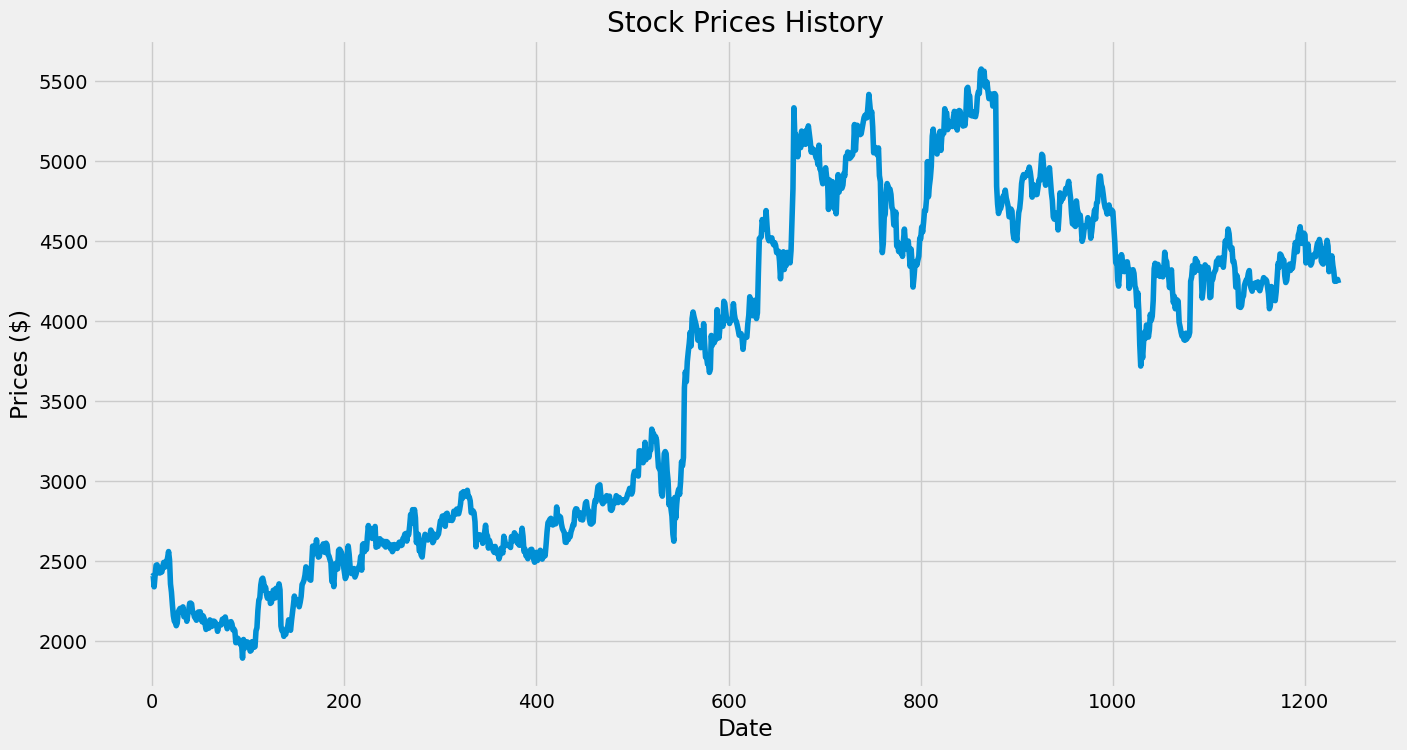

In [4]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [5]:
# Getting the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)

In [6]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [7]:
# Creating the training data set
train_data = scaled_data[0:training_data_len, :]

In [8]:
# Splitting the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [9]:
# Converting the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshaping the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [10]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [11]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [35]:
# Training the model
model.fit(x_train, y_train, batch_size=3, epochs=2)

Epoch 1/2
310/310 [==============================] - 17s 56ms/step - loss: 0.0014
Epoch 2/2
310/310 [==============================] - 18s 59ms/step - loss: 0.0014


In [36]:
# Creating the testing data set
test_data = scaled_data[training_data_len - 60:, :]

# Creating the x_test and y_test data sets
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Converting the data to a numpy array
x_test = np.array(x_test)

# Reshaping the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [37]:
# Getting the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


8/8 [==============================] - 0s 18ms/step


In [38]:
# Getting the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('RMSE:', rmse)


RMSE: 22.274185699455998


In [39]:
# Plotting the data
train = data[:training_data_len]
valid = data[training_data_len:].copy()

# Create a new column in the valid DataFrame for the predictions
valid['Predictions'] = predictions

# Use the .loc accessor to set the values for the new column
valid.loc[:, 'Predictions'] = predictions

In [40]:
predictions.shape

(247, 1)

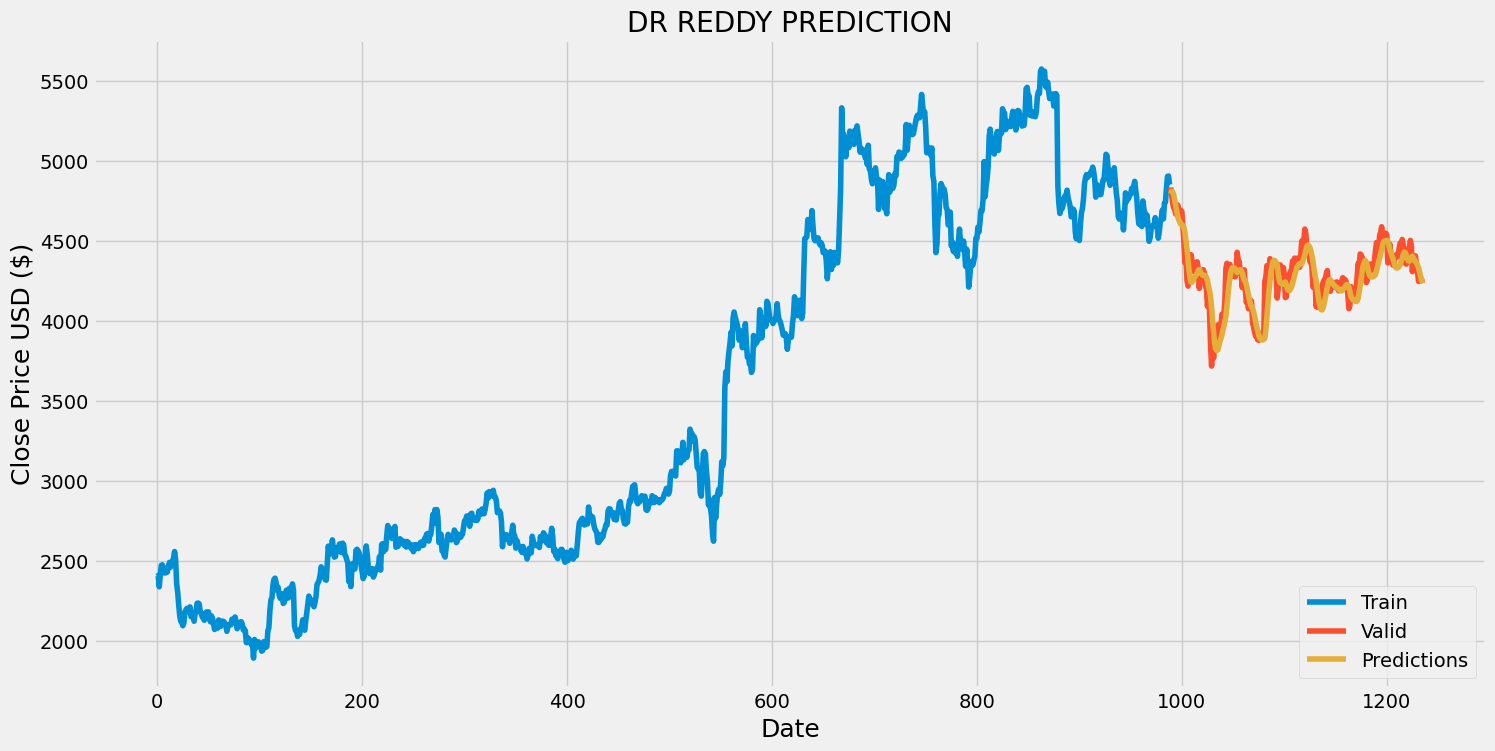

In [41]:
plt.figure(figsize=(16,8))
plt.title('DR REDDY PREDICTION')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

In [42]:
# Predicting the stock prices for the next 365 days
DR_Reddy_quote = pd.read_csv('/content/DRREDDY.NS.csv')
new_df = DR_Reddy_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print('Predicted price for the next day:', pred_price)


1/1 [==============================] - 0s 47ms/step
Predicted price for the next day: [[4222.134]]


In [43]:
forecast = []
forecast.append(pred_price)

for i in range(1, 365):
    last_60_days_scaled = scaler.transform(last_60_days[-60:].reshape(-1, 1))
    last_60_days = np.append(last_60_days[1:], pred_price)
    X_test = np.array([last_60_days_scaled])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    forecast.append(pred_price)

1/1 [==============================] - 0s 32ms/step


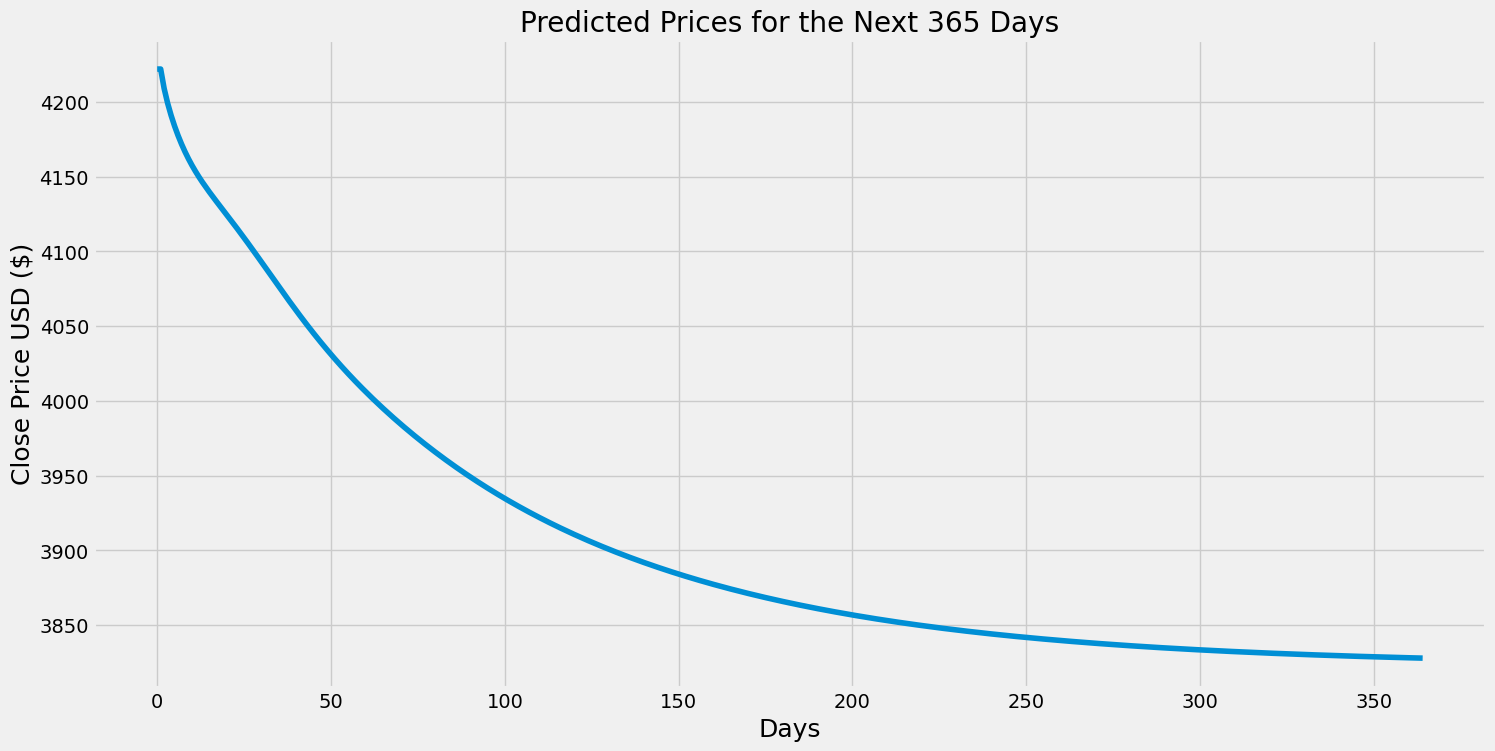

In [44]:
forecast = np.array(forecast).flatten()
plt.figure(figsize=(16,8))
plt.title('Predicted Prices for the Next 365 Days')
plt.xlabel('Days', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(forecast)
plt.show()

In [45]:
forecast

array([4222.134 , 4222.134 , 4209.1064, 4199.312 , 4191.1187, 4183.987 ,
       4177.6436, 4171.936 , 4166.7617, 4162.043 , 4157.7095, 4153.701 ,
       4149.9585, 4146.4326, 4143.0747, 4139.8438, 4136.706 , 4133.631 ,
       4130.595 , 4127.573 , 4124.5503, 4121.5146, 4118.458 , 4115.3735,
       4112.2563, 4109.106 , 4105.9233, 4102.714 , 4099.4756, 4096.214 ,
       4092.9365, 4089.6475, 4086.353 , 4083.0583, 4079.7676, 4076.4873,
       4073.2234, 4069.9805, 4066.7617, 4063.5708, 4060.414 , 4057.2913,
       4054.2073, 4051.166 , 4048.1663, 4045.21  , 4042.2961, 4039.4265,
       4036.6018, 4033.8213, 4031.0862, 4028.3982, 4025.7515, 4023.1482,
       4020.5864, 4018.0662, 4015.5872, 4013.148 , 4010.746 , 4008.3816,
       4006.0527, 4003.7595, 4001.4998, 3999.2727, 3997.0781, 3994.9148,
       3992.7817, 3990.678 , 3988.6033, 3986.5562, 3984.5366, 3982.544 ,
       3980.5776, 3978.637 , 3976.721 , 3974.8306, 3972.9636, 3971.1206,
       3969.3013, 3967.5059, 3965.7327, 3963.982 , 